In [71]:
ALGORITHM = 'Neural Network'
ALGORITHM_DETAIL = ''
ALGORITHM_DETAIL_ORIG = ALGORITHM_DETAIL
ALGORITHM_DETAIL += ' [input11, d^20-500-500-20-5, dense1]'
DATA_DETAIL = []
#DATA_DETAIL = ['no scale','no dummies']
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

#OVERRIDE_CV, OVERRIDE_N_ITER, OVERRIDE_JOBS = None, None, None

In [2]:
! pip install scikeras
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 20.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 62.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 13.1 MB/s eta 0:00:00


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scikeras.wrappers import KerasClassifier, KerasRegressor

import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

print(tf.__version__)


def make_regression_ann(initializer='uniform', activation='relu', optimizer='adam', loss='mse'):
    normalizer = tf.keras.layers.Normalization(axis=-1)
    model = Sequential()
    #model.add(normalizer)
    model.add(Dense(11, input_shape=(len(X_train[0]),), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1))
    model.compile(loss=loss, optimizer=optimizer)
    #print(model)
    return model


2.9.1


In [4]:
#confirm_colab = True
confirm_colab = False
IN_CLOUD = False

from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())
print(env_vars)

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
#OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
#OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
#OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None

no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL
not_catboost = True

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_20221109 import set_csv_directory, get_columns
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters

    set_csv_directory('final_split')
else:
    cloud_run = True
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

        #_20221116
    from functions_0__common_20221116 import get_columns
    from functions_d1__prepare_cleanse_data_20221116 import tidy_dataset
    from functions_d2__transform_enrich_data_20221116 import preprocess, feature_engineer
    from functions_d3__prepare_store_data_20221116 import create_train_test_data
    from functions_e__train_model_20221116 import get_chosen_model, make_modelling_pipeline, get_cv_params, fit_model_with_cross_validation, get_hyperparameters
    from functions_f_evaluate_model_20221116 import get_best_estimator_average_time, get_results, update_results
    
    #set_csv_directory

if quick_mode:
    OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

if 'neural' in ALGORITHM.lower():
    OVERRIDE_JOBS=1

if 'neural' in ALGORITHM.lower() and not cloud_run:
    OVERRIDE_N_ITER = 2

{'notebook_environment': 'gradient', 'use_gpu': True, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [5]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [6]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if cloud_run:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [7]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v06.csv
(46871, 9)


In [8]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD


In [9]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [10]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [11]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [12]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [13]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895


In [14]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)


(39714, 11) (4413, 11) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [15]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [16]:
starter_pipe = make_modelling_pipeline(KerasRegressor(make_regression_ann, verbose=0), DATA_DETAIL)
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 KerasRegressor(model=<function make_regression_ann at 0x7fbe3e8025e0>, verbose=0))])

In [17]:
starter_model = starter_pipe[-1]
default_model_params = starter_model.get_params()
default_model_params

{'model': <function __main__.make_regression_ann(initializer='uniform', activation='relu', optimizer='adam', loss='mse')>,
 'build_fn': None,
 'warm_start': False,
 'random_state': None,
 'optimizer': 'rmsprop',
 'loss': None,
 'metrics': None,
 'batch_size': None,
 'validation_batch_size': None,
 'verbose': 0,
 'callbacks': None,
 'validation_split': 0.0,
 'shuffle': True,
 'run_eagerly': False,
 'epochs': 1}

In [18]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [19]:
# SKIP %timeit starter_pipe.fit(X_train, y_train)

In [20]:
if False:
    options_block = {
        'model__model__initializer': ['normal'], #, 'uniform'],
        'model__model__activation': ['relu'],
        'model__optimizer': ['adam'],
        'model__loss': ['mse'],
        'model__verbose':[0],
        #'model__batch_size': [64, 132] if cloud_run else [1000, 5000],
        'model__batch_size': [264*8] if cloud_run else [1000, 5000],
        #'model__epochs': [1000, 5000] if cloud_run else [5,10,15],
        'model__epochs': [1000, 2000] if cloud_run else [5,10,15],
    }

    redundant, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                      override_cv=OVERRIDE_CV,
                                                                      override_niter=OVERRIDE_N_ITER,
                                                                      override_njobs=OVERRIDE_JOBS)


    def automl_step(param_options, vary):
        for key, value in param_options.items():
            #print(key, value, vary)
            if key != vary and key != 'model__' + vary:
                param_options[key] = [param_options[key][0]]
        return param_options

    options_block = automl_step(options_block, "model__epochs")
    pipeline_search_cv = make_modelling_pipeline(KerasRegressor(make_regression_ann, verbose=1), DATA_DETAIL)

    options_block, cv, n_jobs, refit, n_iter

In [73]:
if False:
    pass
elif False:
    ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG  + 'my model (make_regression_ann)'

    simple_model = make_regression_ann()
    trainable_model = simple_model
elif False:
    ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG  + 'simplest findable model + normalise, mae'

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(X_train))

    even_simpler_model = tf.keras.Sequential([
        normalizer,
        layers.Dense(units=1)
    ])

    even_simpler_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
        loss='mean_absolute_error')
    
    trainable_model = even_simpler_model

elif True:
    ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG  + 'simplest findable model + normalise, MSE loss'

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(X_train))

    even_simpler_model = tf.keras.Sequential([
        normalizer,
        layers.Dense(units=1)
    ])

    even_simpler_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
        loss='mean_squared_error')
    
    trainable_model = even_simpler_model

else:
    pass

In [40]:
#%%time
#history = starter_pipe[-1].fit(
#history = simple_model.fit(
history = trainable_model.fit(
    X_train,
    y_train,
    epochs=100,
    # verbose=0 to suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
)

Epoch 1/100
993/993 [==============================] - 3s 2ms/step - loss: 425005.1562 - val_loss: 425891.1875
Epoch 2/100
993/993 [==============================] - 2s 2ms/step - loss: 424905.6875 - val_loss: 425792.5312
Epoch 3/100
993/993 [==============================] - 2s 2ms/step - loss: 424806.3438 - val_loss: 425693.3438
Epoch 4/100
993/993 [==============================] - 2s 2ms/step - loss: 424706.6250 - val_loss: 425594.2812
Epoch 5/100
993/993 [==============================] - 3s 3ms/step - loss: 424607.5000 - val_loss: 425495.4062
Epoch 6/100
993/993 [==============================] - 2s 2ms/step - loss: 424508.1875 - val_loss: 425396.6250
Epoch 7/100
993/993 [==============================] - 2s 2ms/step - loss: 424408.9062 - val_loss: 425297.5000
Epoch 8/100
993/993 [==============================] - 3s 3ms/step - loss: 424309.7812 - val_loss: 425198.5625
Epoch 9/100
993/993 [==============================] - 2s 2ms/step - loss: 424210.0625 - val_loss: 425099.4688
E

In [41]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,415563.50000,416487.12500,95
96,415464.43750,416388.43750,96
97,415365.59375,416290.03125,97
98,415266.75000,416191.46875,98
99,415167.87500,416092.75000,99


In [42]:
if False:
    def fit_model_with_cross_validation(gs, X_train, y_train, fits):
        pipe_start = time()
        cv_result = gs.fit(X_train, y_train)
        gs.fit(X_train, y_train)
        pipe_end = time()
        average_time = round((pipe_end - pipe_start) / (fits), 2)

        print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
        print()
        print(
            f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
        print(
            f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
        print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

        #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
        return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


    crossval_runner = GridSearchCV(
        estimator=pipeline_search_cv,
        param_grid=options_block,
        cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
        verbose=1, scoring=CROSS_VALIDATION_SCORING,
        refit=refit,
        return_train_score=True, #n_iter=n_iter,
        error_score='raise'
    )

    cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
        crossval_runner, X_train, y_train, fits=cv * n_iter)


In [43]:
if False:
    def fit_model_with_cross_validation(gs, X_train, y_train, fits):
        pipe_start = time()
        cv_result = gs.fit(X_train, y_train)
        gs.fit(X_train, y_train)
        pipe_end = time()
        average_time = round((pipe_end - pipe_start) / (fits), 2)

        print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
        print()
        print(
            f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
        print(
            f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
        print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

        #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
        return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


    crossval_runner = GridSearchCV(
        estimator=pipeline_search_cv,
        param_grid=options_block,
        cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
        verbose=1, scoring=CROSS_VALIDATION_SCORING,
        refit=refit,
        return_train_score=True, #n_iter=n_iter,
        error_score='raise'
    )

    cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
        crossval_runner, X_train, y_train, fits=cv * n_iter)


In [44]:
if False:
    def fit_model_with_cross_validation(gs, X_train, y_train, fits):
        pipe_start = time()
        cv_result = gs.fit(X_train, y_train)
        gs.fit(X_train, y_train)
        pipe_end = time()
        average_time = round((pipe_end - pipe_start) / (fits), 2)

        print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
        print()
        print(
            f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
        print(
            f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
        print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

        #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
        return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


    crossval_runner = GridSearchCV(
        estimator=pipeline_search_cv,
        param_grid=options_block,
        cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
        verbose=1, scoring=CROSS_VALIDATION_SCORING,
        refit=refit,
        return_train_score=True, #n_iter=n_iter,
        error_score='raise'
    )

    cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
        crossval_runner, X_train, y_train, fits=cv * n_iter)


In [45]:
if False:
    def fit_model_with_cross_validation(gs, X_train, y_train, fits):
        pipe_start = time()
        cv_result = gs.fit(X_train, y_train)
        gs.fit(X_train, y_train)
        pipe_end = time()
        average_time = round((pipe_end - pipe_start) / (fits), 2)

        print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
        print()
        print(
            f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
        print(
            f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
        print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

        #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
        return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


    crossval_runner = GridSearchCV(
        estimator=pipeline_search_cv,
        param_grid=options_block,
        cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
        verbose=1, scoring=CROSS_VALIDATION_SCORING,
        refit=refit,
        return_train_score=True, #n_iter=n_iter,
        error_score='raise'
    )

    cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
        crossval_runner, X_train, y_train, fits=cv * n_iter)


In [46]:
if False:
    def fit_model_with_cross_validation(gs, X_train, y_train, fits):
        pipe_start = time()
        cv_result = gs.fit(X_train, y_train)
        gs.fit(X_train, y_train)
        pipe_end = time()
        average_time = round((pipe_end - pipe_start) / (fits), 2)

        print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
        print()
        print(
            f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
        print(
            f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
        print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

        #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
        return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


    crossval_runner = GridSearchCV(
        estimator=pipeline_search_cv,
        param_grid=options_block,
        cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
        verbose=1, scoring=CROSS_VALIDATION_SCORING,
        refit=refit,
        return_train_score=True, #n_iter=n_iter,
        error_score='raise'
    )

    cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
        crossval_runner, X_train, y_train, fits=cv * n_iter)


In [47]:
if False:
    crossval_runner.best_params_

NameError: name 'crossval_runner' is not defined

In [ ]:
if False:
    best_estimator_pipe = crossval_runner.best_estimator_

    if debug_mode:
        crossval_runner.cv_results_

In [ ]:
if False:
    cv_results_df = pd.DataFrame(crossval_runner.cv_results_)

    cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

    cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time','params']
    # if 'Neural' not in ALGORITHM:
    #     cv_columns.insert(2, 'mean_train_score')

    cv_results_df_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)
    cv_results_df_sorted

In [ ]:
if False:
    def print_results(cross_validation_result):
        means = cross_validation_result.cv_results_['mean_test_score']
        stds = cross_validation_result.cv_results_['std_test_score']
        params = cross_validation_result.cv_results_['params']
        times = cross_validation_result.cv_results_['std_test_score']

        print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
        print()
        for mean, std, param, time in zip(means, stds, params, times):
            #param2 = "/".join(list(param.values()))
            param2 = "/".join(list([str(c) for c in param.values()]))
            print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')


    if debug_mode:
        print_results(crossval_runner)

In [ ]:
if False:
    print('Best Index: ', crossval_runner.best_index_)
    print('Best Score: ', crossval_runner.best_score_)
    print('Best Params: ', crossval_runner.best_params_)

In [51]:
#y_pred = best_estimator_pipe.predict(X_test)
y_pred = trainable_model.predict(X_test)

138/138 [==============================] - 0s 1ms/step


In [52]:
y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Neural Network----------
R square Accuracy -15.258654434184194
Mean Absolute Error Accuracy 415136.886075011
Mean Squared Error Accuracy 183664355467.2019
Root Mean Squared Error 428560.79553221137


In [53]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [54]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754,400000.0,9982.724609,390017.275391,97.504319,3906.922114
119328242,369950.0,9381.721680,360568.278320,97.464057,3843.306065
125716790,350000.0,10138.261719,339861.738281,97.103354,3352.268345
122440040,549000.0,10503.018555,538496.981445,98.086882,5127.068744
120508103,495000.0,10705.625000,484294.375000,97.837247,4523.737521
...,...,...,...,...,...
68620869,475000.0,7454.259766,467545.740234,98.430682,6272.195428
85735665,575000.0,7374.113281,567625.886719,98.717546,7697.547692
125706338,400000.0,10296.304688,389703.695312,97.425924,3784.888920


In [55]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted','actual','Price','bedrooms','bathrooms']] = combined[['predicted','actual','Price','bedrooms','bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
122163500,525000,4021,520978.353027,99.233972,12954.353193,525000,5,3,3.095469,51.308888,0.029615,0.190832,0.134035,FREEHOLD
118812035,545000,4708,540291.895996,99.136128,11475.785062,545000,5,2,2.920496,51.313600,0.031600,0.186120,0.136020,FREEHOLD
118942277,600000,5714,594285.017090,99.047503,10398.719059,600000,3,2,2.406950,51.320698,0.025764,0.179022,0.130184,FREEHOLD
122889161,535000,5415,529584.444824,98.987747,9778.950221,535000,4,2,2.487032,51.319158,0.026124,0.180562,0.130544,FREEHOLD
123232451,600000,6437,593562.528320,98.927088,9220.429353,600000,3,2,1.287986,51.303870,-0.109390,0.195850,0.004970,FREEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123427112,175000,11211,163788.310547,93.593320,1460.870917,175000,1,1,0.069943,51.501222,0.060959,0.001502,0.165379,LEASEHOLD
122265818,160000,10309,149690.303711,93.556440,1451.937084,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
100777598,170000,11224,158775.708984,93.397476,1414.572277,170000,1,1,0.196980,51.570578,0.128421,0.070858,0.232841,LEASEHOLD
85667184,122000,10058,111941.248047,91.755121,1112.874128,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD


In [56]:
#score = best_estimator_pipe.score(X_test, y_test)
score = trainable_model.score(X_test, y_test)
score

AttributeError: 'Sequential' object has no attribute 'score'

In [65]:
r2score = r2_score(y_test, y_pred)
r2score

-15.258654434184194

138/138 [==============================] - 0s 1ms/step


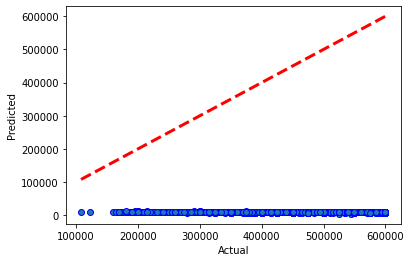

In [59]:
fig, ax = plt.subplots()
#ax.scatter(y_test, best_estimator_pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.scatter(y_test, trainable_model.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [60]:
def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
    graph_model = model
    graph_model.set_params(**graph_params)
    graph_model.fit(X_train, y_train)
    y_pred_graph = model.predict(X_test)

    return model, y_pred_graph


best_model_count = 10 if not quick_mode else 2
best_model_count = 3 if not quick_mode else 1
best_models = {}
best_model_predictions = {}
best_model_scores = {}

showable_increment = total_fits // 4 if not quick_mode else 2

if showable_increment == 0:
    print("WARNING: Did not produce three or more results")
    showable_increment = 1
    
for i in range(0, total_fits, showable_increment):
    if debug_mode or True: print(f'{i} ==> {i}')

    if i == 0:
        fitted_graph_model = crossval_runner.best_estimator_
        y_pred_graph = y_pred
    else:
        graph_pipe_params = cv_results_df_sorted['params'][i]
        print (graph_pipe_params)
        # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

        graph_params = {}
        for key, value in graph_pipe_params.items():
            graph_params[key.replace('model__', '')] = value

        fitted_graph_model, y_pred_graph = custom_model_and_predictions(starter_pipe, graph_pipe_params, X_train,
                                                                        y_train, X_test)

    best_models[i] = fitted_graph_model[-1].get_params()
    best_model_predictions[i] = y_pred_graph
    best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

if debug_mode or True: print(f'{-1} ==> {-1}')
graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
print (graph_pipe_params)
graph_params = {}
for key, value in graph_pipe_params.items():
    graph_params[key.replace('model__', '')] = value
fitted_graph_model, y_pred_graph = custom_model_and_predictions(starter_pipe, graph_pipe_params, X_train,
                                                                y_train, X_test)
best_models[-1] = fitted_graph_model[-1].get_params()
best_model_predictions[-1] = y_pred_graph
best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


NameError: name 'total_fits' is not defined

In [61]:
cv_results_df_sorted

NameError: name 'cv_results_df_sorted' is not defined

In [62]:
cv_results_df_sorted['params']

NameError: name 'cv_results_df_sorted' is not defined

In [ ]:
total_fits

In [ ]:
best_models

In [ ]:
for i in best_model_scores.keys():
    if i >= 0:
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
        plt.scatter(y_test, best_model_predictions[i])
        # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
        plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
        plt.show()

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.scatter(y_test, best_model_predictions[-1])
# plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i))
plt.show()

In [ ]:
if True:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [ ]:
cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
#cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
cv_best_model_fit_time

In [82]:
# <catboost.core.CatBoostRegressor object at 0x7fb167387490>
# {'depth': 6}
# defaultdict(<class 'list'>, {'iterations': [0, 1, 2],
# 'test-RMSE-mean': [396884.9605444017, 359548.6632536235, 326027.84885587444],
# 'test-RMSE-std': [308.9495320039113, 260.0967808594464, 219.65856329246023],
# 'train-RMSE-mean': [396884.77936957515, 359542.3612912551, 326018.9404460669],
# 'train-RMSE-std': [91.44140078375503, 86.77961380623475, 69.4038638987425]})

#cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"] if not_catboost else 999
if False:
    cv_best_model_fit_time = 999

    DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
    key = f'{ALGORITHM} - {ALGORITHM_DETAIL}{DD2} (v{VERSION})'.lower()

    results = {
        #'_score': score,
        '_score': r2score,
        'R square Accuracy': R2,
        'Mean Absolute Error Accuracy': MAE,
        'Mean Squared Error Accuracy': MSE,
        'Root Mean Squared Error': RMSE,
        '_train time': cv_best_model_fit_time,
        'random_state': RANDOM_STATE,
        'date': str(datetime.now()),
        #'_params': crossval_runner.best_params_ if not_catboost else cat_params,
        '_params': 'not available',
        '_method': ALGORITHM_DETAIL,
        'run_env': run_env
    }

    if run_env not in ['colab']:
        results_json = get_results()
        this_model_is_best = update_results(results_json, results, key)

    print(key, this_model_is_best, )
else:
    #cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"] if not_catboost else 999
    cv_best_model_fit_time = 999


    DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
    key = f'{ALGORITHM} (v{VERSION})'.lower()

    method =  f"{ALGORITHM_DETAIL}{DD2}"

    new_results = {
        #'_score': score,
        '_score': r2score,
        'R square Accuracy': R2,
        'Mean Absolute Error Accuracy': MAE,
        'Mean Squared Error Accuracy': MSE,
        'Root Mean Squared Error': RMSE,
        '_train time': cv_best_model_fit_time,
        'random_state': RANDOM_STATE,
        'date': str(datetime.now()),
        #'_params': crossval_runner.best_params_ if not_catboost else cat_params,
        '_params': 'not available',
        '_method':method,
        'run_env': run_env
    }

    if run_env not in ['colab']:
        old_results_json = get_results()
        try:
            old_best_score = old_results_json[key]['best score']
        except:
            print(f"haven't scored this model yet: {ALGORITHM}")
            old_best_score = -999
        this_model_is_best = update_results(old_results_json, new_results, key)

    print(key)

neural network (v06)


In [ ]:
crossval_runner.best_estimator_

In [83]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
#        if not_catboost:
#            pickle.dump(crossval_runner.best_estimator_, f)
#        else:
#            pickle.dump(starter_model, f)
        pickle.dump(trainable_model, f)
        print('pickled new version of model')
        print(f"{old_results_json[key]['_score']} is new best score (it's better than {old_best_score})")
        #print(results_json[key]['_score'], 'is an improvement on', results_json[key]['second best score'])
else:
    print("not updated saved model, the previous run was better")
    print(old_results_json[key]['_score'], 'is worse than or equal to', old_best_score)


not updated saved model, the previous run was better
-15.258654434184194 is worse than or equal to 0.5566961181655233


In [ ]:
feature_importances = crossval_runner.best_estimator_[-1].feature_importances_
#std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

indices = np.argsort(feature_importances)[::-1]

print('Feature Ranking:')

for f in range(X_train.shape[1]):
    print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]),
          df_features.columns[indices[f] + 1])


In [ ]:
feature_importances = crossval_runner.best_estimator_[-1].feature_importances_
indices = np.argsort(feature_importances)

fig, ax = plt.subplots()
ax.barh(range(len(feature_importances)), feature_importances[indices])
ax.set_yticks(range(len(feature_importances)))
_ = ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])